In [3]:
# importing required libaries

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [4]:
# Equilibrium Curve data
def equilibrium_data (alpha = None, po_a=None, po_b=None):
    
    x_eq = np.linspace(0, 1, 51)
    if alpha != None:
        y_eq = (alpha * x_eq)/(1 + (alpha-1)*x_eq)
        return x_eq, y_eq
    
    elif po_a != None and po_b != None:
        alpha = po_a/po_b
        y_eq = (alpha * x_eq)/1 + (alpha-1)*x_eq
        return x_eq, y_eq

# calculating the q line
def yfeed(q, xf, x):
    return (((q*x)/(q-1) - (xf)/(q-1)))

# Calculating q value
def q_calc(Hv, Hf, Hl):
    q = (Hv - Hf)/(Hv-Hl)
    return q

# y Equilibrium curve Equation
def y_equil (alpha, xn):
    return (alpha * xn)/(1 + xn * (alpha - 1))

# x Equiliibrium Curve Equation
def equil (alpha, yn):
    return yn / (alpha - (alpha -1)*yn)

# Rectifying Line Equation
def rect (R, xn, xd):
    return (R/(R+1))*xn + (xd/(R+1))

# Stripping Line Equation
def strip (W, Lm, Vm, xm, xw):
    return (Lm/Vm)*xm - (W/Vm)*xw

# Stream Function
def stream (F, xf, xd, xw):
    W = (((F*xf)-(F*xd)) / (xw - xd))
    D = F - W
    return D, W

# Vapour and Liquid function
def stage_comp(F, q, R, D, W):
    Ln = R*D
    Vn = Ln + D
    Lm = Ln + (q*F)
    Vm = Lm - W
    
    return Ln, Vn, Lm, Vm
    

In [5]:
def x_rect(R, xd, yn):
    return ((yn -(xd/(R+1))) * ((R + 1)/R))

def x_strip(W, xw, Vm, Lm, yn, Vn):
    return ((yn -((W*xw)/Vm)) * (Vn/Lm))


In [6]:

F = 100
alpha = 3
xd = 0.95
xf = 0.5
xw = 0.05
q = 0.5
n = 7
D, W = stream(F, xf, xd, xw)
R=9
def mccabe_eqn_reflux (R):
    
    count = 0
    # calculating important variables of the rectifying and stripping equation
    Ln, Vn, Lm, Vm = stage_comp(F, q, R, D, W)
    
    # intersect of two operating lines
    intersect_x = (-(xd*Vm) - (W*xw*(R+1)))/((R*Vm) - ((R*Lm) + Lm))    # gotten from equating operating line
    #intersect_x = ((xf * (R + 1)) + (xd *(q-1)))/(R+q)                 # gotten from equating q line and rect line
    
    # setting starting values
    yn = xd
    xn = xd
    
    # iterating over the number of stages
    #while count < n:
        # computing the number of stages for Rectifying Section
    while xn > intersect_x and count < n:
            
        # Finding Equilibrium value of x
        xn = equil (alpha, yn)
            
        # the rectifying Component Line Equation
        yn = rect (R, xn, xd)
        count +=1

        
    # computing the number of stages for Stripping Section
    while xn > xw and count < n:
            
        # Finding Equilibrium value of x
        xn = equil (alpha, yn)
            
        # the stripping Component Line Equation
        yn = strip (W, Lm, Vm, xn, xw)
        count +=1        
    
    
    return abs(yn - xw)
        


res = minimize_scalar(mccabe_eqn_reflux)
res.x


# Function to calculate minimum reflux ratio
def min_reflux(alpha, xf, xd):
    Rmin = ((1/(alpha-1)) * ((xd/xf) - ((alpha*(1-xd))/(1-xf))))
    return Rmin

3.5916489564700895

In [7]:
# Function to find the bottom composition


F = 100
alpha = 3
xd = 0.95
xf = 0.5
xw = 0.5
q = 0.5
n = 7
R=3.59164


def mccabe_eqn_bottom (xw):
    D, W = stream(F, xf, xd, xw)
    count = 0
    # calculating important variables of the rectifying and stripping equation
    Ln, Vn, Lm, Vm = stage_comp(F, q, R, D, W)
    
    # intersect of two operating lines
    intersect_x = (-(xd*Vm) - (W*xw*(R+1)))/((R*Vm) - ((R*Lm) + Lm))
    
    # setting starting values
    yn = xw
    xn = xw
    
    
    # iterating over the number of stages
    #while count < n:
        
    # computing the number of stages for Stripping Section
    while xn <= intersect_x and count < n:      
        # Finding Equilibrium value of x
        yn = y_equil (alpha, xn)
            
        # the stripping Component Line Equation
        xn = x_strip (W, xw, Vm, Lm, yn, Vn)
        count +=1 
        
    # computing the number of stages for Rectifying Section
    while yn < xd and count < n:
        # Finding Equilibrium value of x
        yn = y_equil (alpha, xn)
                
        # the rectifying Component Line Equation
        xn = x_rect (R, xd, yn)
        count +=1
    
    return abs(yn - xd)
        

res = minimize_scalar(mccabe_eqn_bottom)
res

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 1.968111118522131e-09
       x: 0.7144672274008741
     nit: 35
    nfev: 38

In [11]:
# Function determining Number of Stages

def mccabe_plot (alpha, xd, xw, xf, F, R, q, D=None, W=None, Hv=None, Hf=None, Hl=None):
    # calculating missing values
    if q == None:
        q = q_calc(Hv, Hf, Hl)
    
    # calulating composition
    if D == None and W == None:
        D, W = stream(F, xf, xd, xw)
    # calculating important variables of the rectifying and stripping equation
    Ln, Vn, Lm, Vm = stage_comp(F, q, R, D, W)
    
    # setting starting values
    no_stage = 0
    yn = xd
    xn = xd
    
    # xn and yn points
    xn_points = []
    yn_points = []
    
    # an attempt to calc intersection of operating lines
    intersect_x = (-(xd*Vm) - (W*xw*(R+1)))/((R*Vm) - ((R*Lm) + Lm))
    
    # computing the number of stages for Rectifying Section
    while xn > intersect_x:
        # creating a list points for xn thyline on graph
        xn_thyline = []
        yn_thyline = []
        xn_thyline.append(xn)
        
        # creating a list points for yn thyline on graph
        yn_points.append([yn, yn])
        yn_thyline.append(yn)
        
        # Finding Equilibrium value of x
        xn = equil (alpha, yn)
        
        # creating list of all xn thyline points
        xn_thyline.append(xn)
        xn_points.append(xn_thyline)
        xn_points.append([xn, xn])
        
        # the stripping Component Line Equation
        yn = rect (R, xn, xd)
        
        # counter for number of stages
        no_stage += 1
        
        # creating list of all yn thyline points
        yn_thyline.append(yn)
        yn_points.append(yn_thyline)
        
    feed_plate = no_stage
    
    
    # computing the number of stages for Stripping Section
    xm = xn
    ym = yn
    while xm > xw:
        # creating a list points for xn thyline on graph
        xm_thyline = []
        ym_thyline = []
        xm_thyline.append(xm)
        
        # creating a list points for yn thyline on graph
        yn_points.append([ym, ym])
        ym_thyline.append(ym)
        
        # Finding Equilibrium value of x
        xm = equil (alpha, ym)
        
        # creating list of all xn thyline points
        xm_thyline.append(xm)
        xn_points.append(xm_thyline)
        xn_points.append([xm, xm])
        
        # the stripping Component Line Equation
        ym = strip (W, Lm, Vm, xm, xw)
        
        # counter for number of stages
        no_stage += 1
        
        # creating list of all yn thyline points
        ym_thyline.append(ym)
        yn_points.append(ym_thyline)

    # rect_0 finds the value of rectifying line when xn=0    
    rect_0 = (1/(R+1))*xd
    
    # strip_0 finds the value of stripping line when xn=0
    strip_xf = (Lm/Vm)*xf-(W/Vm)*xw
    
    # q_points finds the points for the q line
    if q != 1:
        #q_x = np.linspace(xd, xw, 5)
        #q_y = q/(q-1)*q_x + (1/(1-q))*xf
        q_y_p = q/(q-1)*xw + (1/(1-q))*xf
        q_x = [xf, xw]
        q_y = [xf, q_y_p]
        q_points = [q_x, q_y]
    else:
        #y_x = (alpha*xf)/(1+(alpha-1)*xf)
        q_points = [[intersect_x, intersect_x], [intersect_x, 1]]
    
    # two x and y points (at x =0, x=xd) for the rectifying line                           
    rect_points = [[0, xd], [rect_0, xd]]
    
    # two x and y points (at xn=0, xn=xd) for the stripping line
    strip_points = [[xf, xw], [strip_xf, xw]]
    
    print(feed_plate)
    #no_stage = no_stage -1 
    #return xm, ym, no_stage, feed_plate
    return xn_points, yn_points, rect_points, strip_points, q_points, no_stage
    
def x_y_plot (x_eq, y_eq, rect_points, strip_points, xn_points, yn_points, q_points, xf, q):
    forty_five_line = [0, 1]
    
    # plotting equilibrium curve
    plt.plot(x_eq, y_eq)
    #plt.scatter(x_eq, y_eq)
    
    # plotting 45 degree line
    plt.plot(forty_five_line, forty_five_line)
    
    # plotting rectifying line
    plt.plot(rect_points[0], rect_points[1])
    
    # plotting stripping line
    plt.plot(strip_points[0], strip_points[1])
    
    # plotting the stages lines
    for i in range(len(xn_points)):
        plt.plot(xn_points[i], yn_points[i])
    
    # plotting the q line
    plt.plot(q_points[0], q_points[1])
    plt.scatter(xf, xf)
    
    # display plots
    plt.show()

4
8


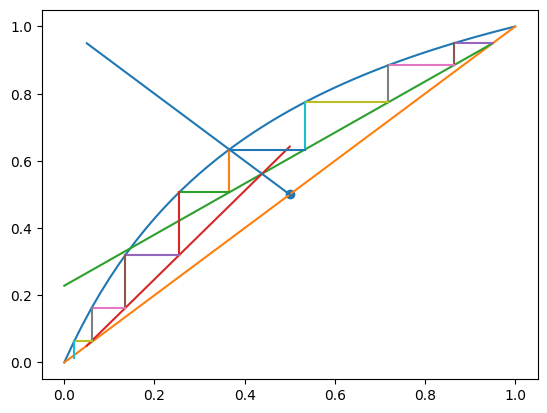

In [12]:
#something wrong
# need material ballace
# answer is 
xn_points, yn_points, rect_points, strip_points, q_points, no_stage = mccabe_plot (alpha=3, xd=0.95, xw=0.05, xf=0.5, F=100, R=3.158, q=0.5)
print(no_stage)
x_eq, y_eq = equilibrium_data(alpha=3)
x_y_plot(x_eq, y_eq, rect_points, strip_points, xn_points, yn_points, q_points, xf=0.5, q=0.5)

6
12


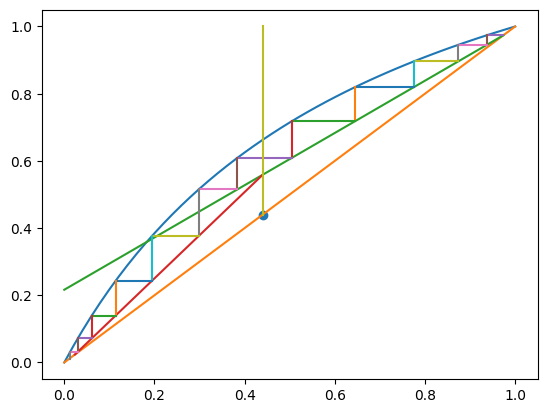

In [105]:
xn_points, yn_points,rect_points, strip_points, q_points, no_stage = mccabe_plot (alpha=2.5, xd=0.974, xw=0.0235, xf=0.44, F=350, R=3.5, D=153.4, W=196.6, q=1)
x_eq, y_eq = equilibrium_data(alpha=2.5)
print(no_stage)
x_y_plot(x_eq, y_eq, rect_points, strip_points, xn_points, yn_points, q_points, xf=0.44, q=1)

4
8


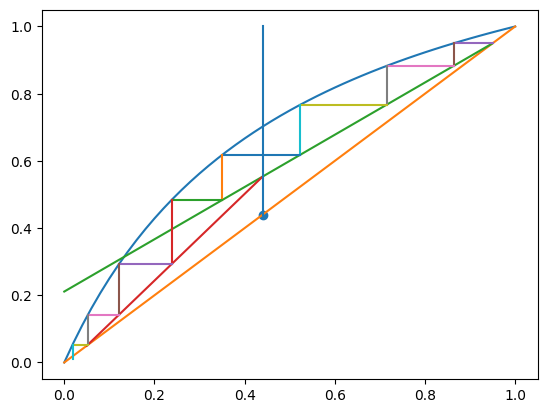

In [106]:
xn_points, yn_points,rect_points, strip_points, q_points, no_stage = mccabe_plot (alpha=3, xd=0.95, xw=0.05, xf=0.44, F=350, R=3.5, q=1)
x_eq, y_eq = equilibrium_data(alpha=3)
print(no_stage)
x_y_plot(x_eq, y_eq, rect_points, strip_points, xn_points, yn_points, q_points, xf=0.44, q=1)